# Code for "Multiple molecular responses to mineral particles in natural colonies of the cyanobacterium Trichodesmium", Held et al., 2020

Note: code is presented as an example only for reproducibility and educational purposes. 

# Dependencies

In [1]:
import pandas as pd
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats, f_oneway, mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Prior to analysis download the data for the JGI genome: https://genome.jgi.doe.gov/portal/Tricyacommsample_FD/Tricyacommsample_FD.download.html and fill path in below cell

In [1]:
pathtofile = <path to JGI genome annotations>

SyntaxError: invalid syntax (<ipython-input-1-41c9c46cdd6f>, line 1)

# Read files

In [33]:
# A truncated version data is provided; full data will be released upon publication
dataFile = pd.read_csv("2000521_samplesreport_truncated.csv").set_index("Accession")[:-2]

# taxonomy annotations for TCCM proteins
taxonomyFile = pd.read_table(pathtoannotations + '/2156126005.taxonomy.txt, header=0)
taxonomyFile.columns=['Accession', 'Number', 'Number2', 'Decimal', 'Taxonomy_annotated']
taxonomyFile = taxonomyFile.set_index('Accession')

# protein annotations for TCCM proteins
productFile = pd.read_table(pathtoannotations + '/2156126005.a.gene_product.txt', header=0)
productFile.columns=['Accession', 'Product Name']
productFile = productFile.set_index('Accession')

# map KO values to descriptions
koFile = pd.read_table(pathtoannotations + '/2156126005.a.ko.txt', header=0)
koFile.columns=['Accession', 'KO']

# map COG values to descriptions
COGFile = pd.read_table(pathtoannotations + '/2156126005/2156126005.a.cog.txt', header=0)
COGFile.columns=['Accession', 'COG_accession']

# merge the files
combined = pd.concat([dataFile, taxonomyFile, productFile], axis=1, join='inner').reset_index()
combined2 = combined.merge(COGFile, left_on='Accession', right_on='Accession', how='left')

#combined2 now contains all the TCCM proteins only
combined2[['tax0', 'tax1', 'tax2', 'tax3', 'tax4', 'tax5', 'tax6', 'tax7', 'tax8']] = combined2['Taxonomy_annotated'].str.split(';', expand=True)
combined2['taxonomy'] = combined2['tax1']
combined2['genome'] = 'JGI_metaG'

# annotations for refined MAGS from Eric Webb
ericannot = pd.read_csv("200521_flatCOGannotationfile.csv").set_index('Accession')

ericcombined = pd.concat([dataFile, ericannot], axis=1, join='inner').reset_index()

# grab taxonomies based on MAG IDs
erictax = pd.read_csv("MAG_taxonomy.csv")
#genomeIds = erictax['user_genome'].str.split('-contigs').apply(lambda x: x[0])
genomeIds = erictax['noelle_genomeid']
taxonomy = erictax['noelle_placement']
erictaxdf = pd.DataFrame({'genome':genomeIds, "taxonomy":taxonomy})
# only proteins with eric annotations will be assigned a genome here
ericcombined['genome'] = ericcombined['Accession'].str.rsplit('_',1).apply(lambda x: x[0])
ericcombined = ericcombined.merge(erictaxdf, left_on='genome', right_on='genome')

# combine the metaG and MAG annotated dataframes
alldata = combined2.append(ericcombined).set_index("Accession")

# don't forget the st 19 unrefined MAGs, which are not annotated yet and anything that wasn't annotated
unannotated = dataFile[~dataFile.index.isin(alldata.index)]

# assign genome value for the unannotated proteins based on protein ID
unannotated.reset_index(inplace=True)
unannotated['genome'] = unannotated['Accession'].str.rsplit('_',1).apply(lambda x: x[0])
unannotated['Accession'] = unannotated['Accession'].str.split("(").apply(lambda x : x[0])
#unannotated.set_index("Accession", inplace=True)

unannotatedtax = unannotated.merge(erictaxdf, left_on='genome', right_on='genome', how='left')
unannotatedtax['genome'].replace('TCCM', 'JGI_metaG')
unannotatedtax.set_index("Accession", inplace=True)
alldata = alldata.append(unannotatedtax)


for index, row in alldata.iterrows():
    if row['Taxonomy_annotated'] == 'Bacteria;Cyanobacteria;unclassified;Oscillatoriales;unclassified;Trichodesmium;erythraeum;Trichodesmium erythraeum IMS101':
        alldata.loc[index, 'taxonomy'] = 'Trichodesmium'


/Users/noelle/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/noelle/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Set up data grouped by colony type (clean, xmas (with particles), tuft)


In [36]:
transposed = alldata.transpose().iloc[8:-17,:].reset_index()
transposed['type'] = transposed['index'].str[:-2]
di = {'clean':'No particles', 'xmas':'With particles'}
transposed = transposed.replace({"type":di})
# strip the commas from the floats
transposed[transposed.columns] = transposed[transposed.columns].replace({'\$': '', ',': ''}, regex=True)

grouped = transposed.groupby('type')

clean = grouped.get_group('No particles').drop('index', axis=1).drop('type', axis=1).apply(pd.to_numeric)
xmas = grouped.get_group('With particles').drop('index', axis=1).drop('type', axis=1).apply(pd.to_numeric)
tuft = grouped.get_group('tuft').drop('index', axis=1).drop('type', axis=1).apply(pd.to_numeric)

clean

Accession,TCCM_0939.00000010,TCCM_0495.00000020,TCCM_0237.00000020,TCCM_0797.00000210,TCCM_0139.00000040,TCCM_0240.00000030,TCCM_0097.00000010,TCCM_0662.00000020,TCCM_0662.00000030,TCCM_0139.00000020,...,H94_284,bin1_st15_19061,bin1_st16_2_23570,bin1_st15_19164,TCCM_0635.00005400,bin2_st16_tuft_42057,bin1_st15_17946,bin1_st16_1_21040,bin1_st18_26832,bin1_st18_28502
0,10441000.0,10633000.0,4381800.0,23150000.0,2487100.0,10489000.0,6438600.0,12358000.0,15784000.0,5575500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8415200.0,3148200.0,5052000.0,2460300.0,1065900.0,2107800.0,222430.0,4114600.0,1485200.0,2337900.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,4057600.0,1279600.0,6109200.0,4591300.0,1006300.0,3316500.0,4863800.0,21802000.0,4757500.0,1131700.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,33417000.0,7641700.0,32369000.0,18916000.0,3307800.0,16107000.0,4615900.0,24466000.0,39902000.0,3376500.0,...,78184.0,0.0,0.0,112320.0,0.0,0.0,38977.0,302700.0,0.0,97756.0
14,5095500.0,5713100.0,2290400.0,8509000.0,1821200.0,6504900.0,1501900.0,7476500.0,8621200.0,2531200.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,1493900.0,302350.0,2004500.0,418990.0,0.0,1206900.0,608000.0,6380200.0,1495700.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,1328200.0,0.0,1091200.0,137830.0,80547.0,1361300.0,0.0,1294100.0,565100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Run t-test  for each  protein and write to file

In [37]:
# Welch's t-test particle vs no particle puffs
t, p = ttest_ind(clean, xmas, equal_var=False)
alldata['p_cleanvsxmas'] = p

# Welch's t-test no particle puffs vs tufts (some particles)
t, p = ttest_ind(clean, tuft, equal_var=False)
alldata['p_cleanvstuft'] = p

# write to file 
alldata.to_csv('truncateddataset_Trichosinglecolonies_annotated.csv')

# compress into a single dataframe
cleanxmas = pd.concat([clean,xmas, tuft], keys=['Puff no part.', 'Puff w/ part.','Tuft w/ part.']).reset_index()


/Users/noelle/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/noelle/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/noelle/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


# Bar plots for proteins of interest

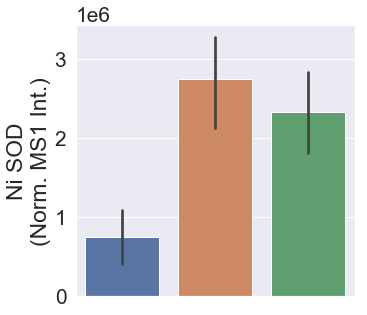

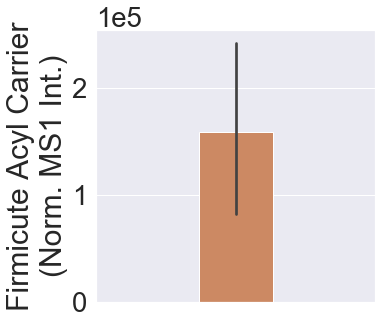

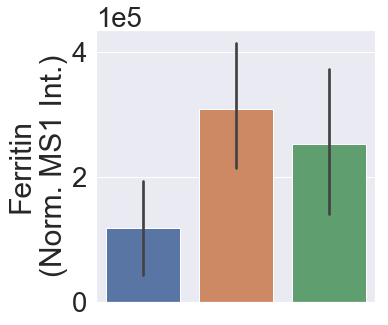

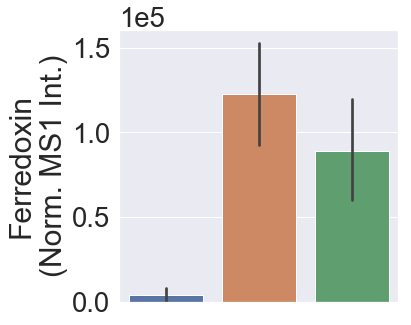

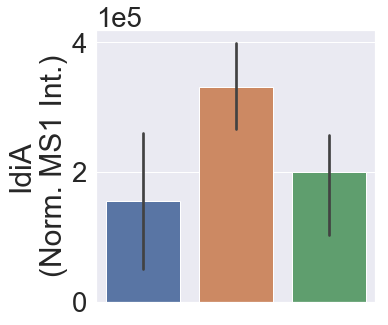

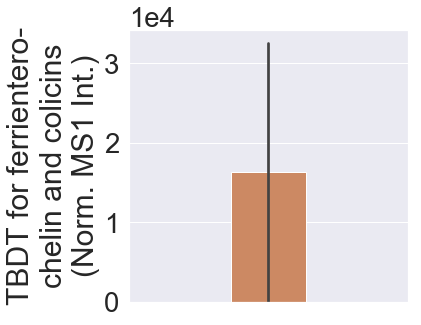

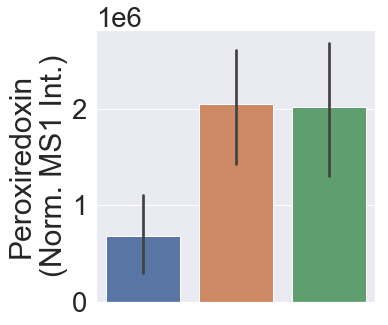

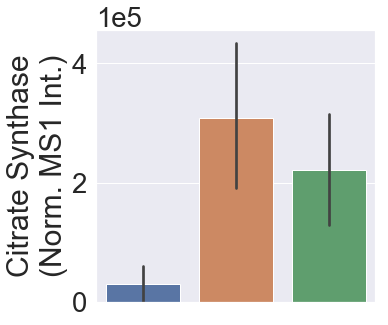

In [63]:
def barplot(protofinterest, label):

    fig, ax = plt.subplots(figsize=(5,5))
    sns.set(font_scale=2.5)

    ax = sns.barplot(x="level_0", y=protofinterest, data=cleanxmas,ci=75)
    ax.set(ylabel=label+'\n'+str('(Norm. MS1 Int.)'),xlabel="")
    #ax.set_xticklabels(['Puff no part', 'Puff w/ part', 'Tuft w/ part'], rotation = 45)
    ax.set_xticklabels("")
    plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

barplot('TCCM_0616.00000020', 'Ni SOD')
barplot("TCCM_0899.00000020", "Firmicute Acyl Carrier")
barplot("TCCM_0250.00000190", 'Ferritin')
barplot("TCCM_0151.00000140", 'Ferredoxin')
barplot("bin2_st14_39696", 'IdiA')
barplot(206, 'TBDT for ferrientero-\nchelin and colicins')
barplot("TCCM_0439.00000030", 'Peroxiredoxin')
barplot(42, "Citrate Synthase")

# Volcano plot

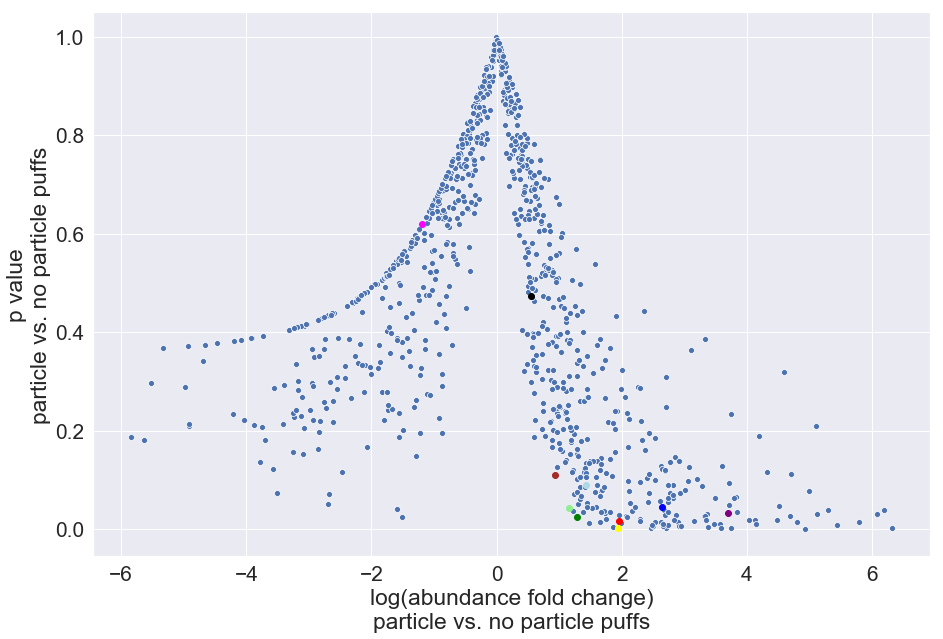

In [62]:
fig, ax = plt.subplots(figsize=(15,10))
sns.set(font_scale=1.9)
vmin, vmax = 0, 1
norm=plt.Normalize(vmin=vmin, vmax=vmax)
z = np.random.rand(0, 1)
cmap = sns.cubehelix_palette(as_cmap=True)

alldata.index.names = ['Accession']
KOoutputnodups = alldata.reset_index()

foldchange = xmas.mean()/clean.mean()
foldchange2 = foldchange.to_frame()
foldchange2.columns = ['foldchangexmasclean']
foldchange2.reset_index(inplace = True)

proteinsdropped2 = pd.merge(KOoutputnodups, foldchange2, on='Accession').set_index("Accession")

proteinsdropped2['log2foldchange'] = proteinsdropped2['foldchangexmasclean'].apply(lambda x: np.log2(x))
proteinsdropped2['volcanocolor'] = sns.cubehelix_palette(as_cmap=True)
p = sns.scatterplot(proteinsdropped2['log2foldchange'],proteinsdropped2['p_cleanvsxmas'])
ax.set(ylabel='p value\nparticle vs. no particle puffs',xlabel="log(abundance fold change)\nparticle vs. no particle puffs")

# below, highlighting specific proteins in the plot

proteinofinterest = 'TCCM_0012.00000020' #NDK
x = proteinsdropped2.loc[proteinofinterest]['log2foldchange']
y = proteinsdropped2.loc[proteinofinterest]['p_cleanvsxmas']
p.scatter(x,y,c='red')

proteinofinterest = 'TCCM_0275.00000010' #Zn peptidase
x = proteinsdropped2.loc[proteinofinterest]['log2foldchange']
y = proteinsdropped2.loc[proteinofinterest]['p_cleanvsxmas']
p.scatter(x,y,c='aqua')

proteinofinterest = 'H94_1201' #plastocyanin
x = proteinsdropped2.loc[proteinofinterest]['log2foldchange']
y = proteinsdropped2.loc[proteinofinterest]['p_cleanvsxmas']
p.scatter(x,y,c='red')

proteinofinterest = 'TCCM_0472.00000070' #Carboxysome
x = proteinsdropped2.loc[proteinofinterest]['log2foldchange']
y = proteinsdropped2.loc[proteinofinterest]['p_cleanvsxmas']
p.scatter(x,y,c='yellow')

proteinofinterest = 'TCCM_0797.00000210' #allophycocyanin
x = proteinsdropped2.loc[proteinofinterest]['log2foldchange']
y = proteinsdropped2.loc[proteinofinterest]['p_cleanvsxmas']
p.scatter(x,y,c='green')

proteinofinterest = 161 #glutamine synth
x = proteinsdropped2.loc[proteinofinterest]['log2foldchange']
y = proteinsdropped2.loc[proteinofinterest]['p_cleanvsxmas']
p.scatter(x,y,c='gold')


proteinofinterest = 'TCCM_0490.00000030' #thioredoxin
x = proteinsdropped2.loc[proteinofinterest]['log2foldchange']
y = proteinsdropped2.loc[proteinofinterest]['p_cleanvsxmas']
p.scatter(x,y,c='blue')


proteinofinterest = 'TCCM_0464.00000030' #Fe peroxidase
proteinofinterest = 'bin1_st19_31023'
x = proteinsdropped2.loc[proteinofinterest]['log2foldchange']
y = proteinsdropped2.loc[proteinofinterest]['p_cleanvsxmas']
p.scatter(x,y,c='purple')


proteinofinterest = 'bin2_st16_tuft_41412' #NifH
x = proteinsdropped2.loc[proteinofinterest]['log2foldchange']
y = proteinsdropped2.loc[proteinofinterest]['p_cleanvsxmas']
p.scatter(x,y,c='magenta')

proteinofinterest = 'TCCM_0427.00000140' #NifK
x = proteinsdropped2.loc[proteinofinterest]['log2foldchange']
y = proteinsdropped2.loc[proteinofinterest]['p_cleanvsxmas']
p.scatter(x,y,c='brown')

proteinofinterest = 'TCCM_0099.00000050' #NifD
x = proteinsdropped2.loc[proteinofinterest]['log2foldchange']
y = proteinsdropped2.loc[proteinofinterest]['p_cleanvsxmas']
p.scatter(x,y,c='black')

proteinofinterest = 'TCCM_0575.00000030' #zn peptidase
x = proteinsdropped2.loc[proteinofinterest]['log2foldchange']
y = proteinsdropped2.loc[proteinofinterest]['p_cleanvsxmas']
p.scatter(x,y,c='pink')

proteinofinterest = 'TCCM_0495.00000020' #rubisco
x = proteinsdropped2.loc[proteinofinterest]['log2foldchange']
y = proteinsdropped2.loc[proteinofinterest]['p_cleanvsxmas']
p.scatter(x,y,c='lightgreen')

proteinofinterest = 124 #citrate synthase
x = proteinsdropped2.loc[proteinofinterest]['log2foldchange']
y = proteinsdropped2.loc[proteinofinterest]['p_cleanvsxmas']
p.scatter(x,y,c='lightblue')

# Taxonomic distributions of protein IDs for the different colony types

In [7]:
for index, row in KOoutputnodups.iterrows():
    if row['Taxonomy_annotated'] == 'Bacteria;Cyanobacteria;unclassified;Oscillatoriales;unclassified;Trichodesmium;erythraeum;Trichodesmium erythraeum IMS101':
        KOoutputnodups.loc[index, 'taxonomy'] = 'Trichodesmium'


grouped2 = KOoutputnodups.groupby('taxonomy').sum()

taxgrouped = grouped2.iloc[:,1:-5].transpose()
taxgrouped['type'] = taxgrouped.index.str[:-2]

typegrouped = taxgrouped.groupby('type').sum().drop('cored')


def cleanupbadannotations(df):
    # Actinobacteria proteins actually BLAST better to non-Tricho cyanos
    df['Cyanobacteria'] += df['Actinobacteria']
    df.drop('Actinobacteria', inplace=True, axis=1)
    
    # Deinococcus proteins actually BLAST better to non-Tricho cyanos
    df['Cyanobacteria'] += df['Deinococcus-Thermus']
    df.drop('Deinococcus-Thermus', inplace=True, axis=1)
    
    # Combine all the eukaryote proteins; most of these hit to copepod models but we are grouping broadly
    df['Eukaryotes'] = df['Arthropoda'] + df['Chordata'] 
    df.drop(["Arthropoda", "Chordata", 'unclassified'], inplace=True, axis = 1)
    
    # Bacteroidetes are microscilla
    df['Microscilla'] += df['Bacteroidetes']
    df.drop('Bacteroidetes', inplace=True, axis = 1)
    
    # PVC group to match new taxonomy standards
    df['PVC_Group'] = df['Planctomycetota'] + df['Kiritimatiella']
    df.drop(["Planctomycetota", "Kiritimatiella"], inplace=True, axis = 1)
        
    df.rename(columns={"Proteobacteria": "Other_Proteobacteria"}, inplace=True)
    return df

typegrouped = cleanupbadannotations(typegrouped)


clean = typegrouped.drop(['tuft','xmas']).transpose().reset_index()
xmas = typegrouped.drop(['tuft','clean']).transpose().reset_index()
tuft = typegrouped.drop(['clean','xmas']).transpose().reset_index()

clean['summedlog'] = np.log(clean['clean']/5).replace(-np.inf, 0)
xmas['summedlog'] = np.log(xmas['xmas']/13).replace(-np.inf, 0)
tuft['summedlog'] = np.log(tuft['tuft']/3).replace(-np.inf, 0)

#clean = clean[clean.summedlog > 10]
#xmas = xmas[xmas.summedlog > 10]
#tuft = tuft[tuft.summedlog > 10]
# remove very low abundance epis

/Users/noelle/miniconda3/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(0, 21)

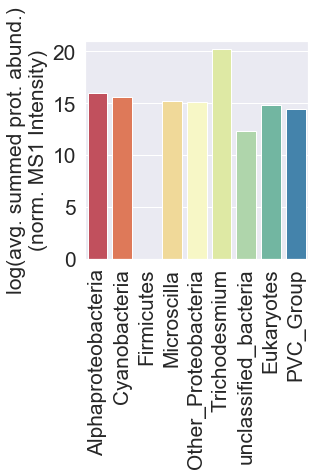

In [8]:
# puffs no particles

fig, axes = plt.subplots(figsize=(4,4))
sns.set(font_scale=1.8)
#clean = clean.reindex([7,6,8,3,0,4,11,9,10,5,2])
sns.barplot(x = 'taxonomy', y = 'summedlog', data=clean, palette='Spectral', ci=None)
plt.xlabel("")
plt.ylabel('log(avg. summed prot. abund.)\n(norm. MS1 Intensity)', fontsize=21)
plt.xticks(rotation=90)
plt.ylim(0, 21)

(0, 21)

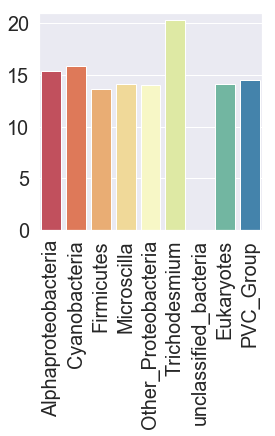

In [9]:
# puffs no particles

fig, ax = plt.subplots(figsize=(4,4))
sns.set(font_scale=1.8)
#xmas = xmas.reindex([7,6,8,3,0,4,11,9,10,5,2])

sns.barplot(x = 'taxonomy', y = 'summedlog', data=xmas, palette='Spectral', ci=None)
plt.xlabel("")
#plt.ylabel('log(avg. summed prot. abund.)\n(norm. MS1 Intensity)', fontsize=21)
plt.ylabel('', fontsize=21)
plt.xticks(rotation=90)
plt.ylim(0, 21)

(0, 21)

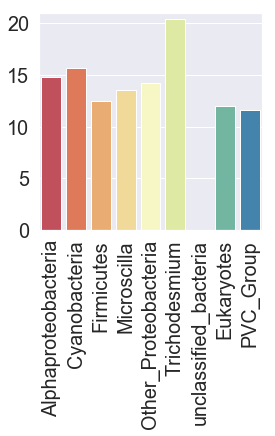

In [10]:
# puffs no particles

fig, ax = plt.subplots(figsize=(4,4))
sns.set(font_scale=1.8)
#tuft = tuft.reindex([7,6,8,3,0,4,11,9,10,5,2])

sns.barplot(x = 'taxonomy', y = 'summedlog', data=tuft, palette='Spectral')
plt.xlabel("")
#plt.ylabel('log(avg. summed prot. abund.)\n(norm. MS1 Intensity)', fontsize=21)
plt.ylabel('', fontsize=21)
plt.xticks(rotation=90)
plt.ylim(0, 21)

In [11]:
# run a Welch's t-test to find out which are different from puffs with no particles

df2 = cleanupbadannotations(taxgrouped)

# special case due to misannotations in the original metagenomes 
df3 = df2.groupby('type')

statclean = df3.get_group('clean').drop('type', axis=1).apply(pd.to_numeric)
statxmas = df3.get_group('xmas').drop('type', axis=1).apply(pd.to_numeric)
stattuft = df3.get_group('tuft').drop('type', axis=1).apply(pd.to_numeric)

#statclean = cleantaxonomy(statclean)
#statxmas = cleantaxonomy(statxmas)
#stattuft = cleantaxonomy(stattuft)

statdf = pd.DataFrame(df3.get_group('clean').drop('type', axis=1).columns) 

t, p = ttest_ind(statclean, statxmas, equal_var=True)
statdf['cleanvsxmas'] = p
t, p = ttest_ind(df3.get_group('clean').drop('type', axis=1).apply(pd.to_numeric), df3.get_group('tuft').drop('type', axis=1).apply(pd.to_numeric), equal_var=True)
statdf['cleanvstuft'] = p
statdf

,taxonomy,cleanvsxmas,cleanvstuft
0,Alphaproteobacteria,0.444520,0.290462
1,Cyanobacteria,0.463829,0.875011
2,Firmicutes,0.257724,0.013249
3,Microscilla,0.374635,0.505796
4,Other_Proteobacteria,0.355712,0.622263
5,Trichodesmium,0.499389,0.705081
6,unclassified_bacteria,0.053953,0.323598
7,Eukaryotes,0.366849,0.036801
8,PVC_Group,0.697235,0.115540


# Heatmaps of Trichodesmium protein functions (based on COG)

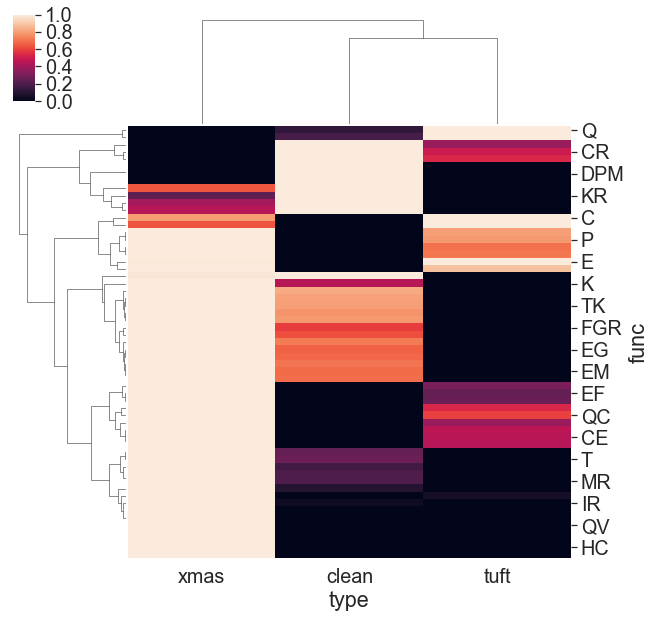

In [12]:
# need to map COGs to cog functions
cogdb = pd.read_csv("cognames2003-2014.csv", encoding='cp1252')
cogdb.drop('name', inplace=True, axis=1)
alldataCOG = alldata.merge(cogdb, left_on='COG_accession', right_on='COG', how='left')
# if in multiple COGs, count as part of each of them


# grab Tricho proteins only
alldataCOGTricho = alldataCOG[alldataCOG['taxonomy'] == 'Trichodesmium']
trichogrouped = alldataCOGTricho.groupby('func').sum().iloc[:,1:-6].transpose()
trichogrouped['type'] = trichogrouped.index.str[:-2]
trichogrouped = trichogrouped.groupby('type').mean()
trichogrouped.drop('cored', inplace=True)
trichogrouped = trichogrouped.transpose()
sns.clustermap(trichogrouped, standard_scale=0)

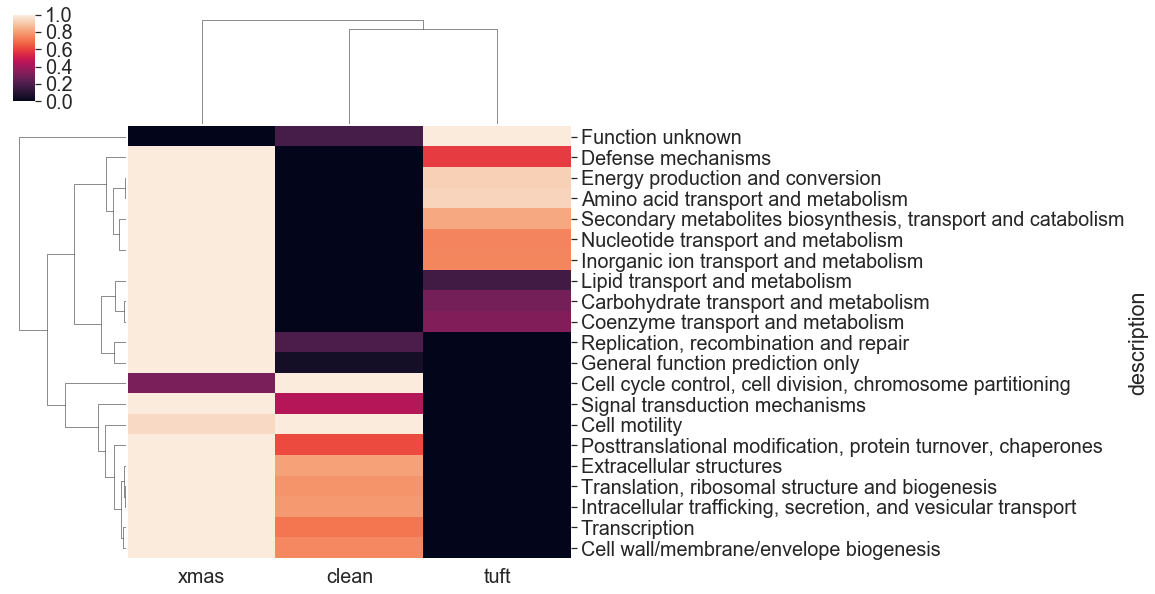

In [21]:
# need to map COGs to cog functions
cogdb = pd.read_csv("cognames2003-2014.csv", encoding='cp1252')
cogdb.drop('name', inplace=True, axis=1)
alldataCOG = alldata.merge(cogdb, left_on='COG_accession', right_on='COG', how='left')

COGmap = pd.read_csv("/Users/noelle/Documents/science_projects/180912_singlecolonies/august2019/eric_research/COGMap.csv", encoding='cp1252', header=None)
COGmap.columns = ['COG' ,'description']
COGmap.set_index("COG")
COGmap['description'] = COGmap['description'].str.split("Ê").apply(lambda x: x[-1])
COGdict = COGmap.to_dict()

# grab Tricho proteins only
alldataCOGTricho = alldataCOG[alldataCOG['taxonomy'] == 'Trichodesmium']
trichogrouped = alldataCOGTricho.groupby('func').sum().iloc[:,1:-6].transpose()
trichogrouped['type'] = trichogrouped.index.str[:-2]
trichogrouped = trichogrouped.groupby('type').mean()
trichogrouped.drop('cored', inplace=True)
trichogrouped = trichogrouped.transpose()

# if in multiple COGs double count to those COGs
letterDict = {}    
for letter in COGmap['COG'].values:
    filtered_df = trichogrouped.filter(regex=r'{}'.format(letter), axis=0)
    filtsum = filtered_df.sum()
    letterDict[letter] = filtsum
toplot = pd.DataFrame.from_dict(letterDict)


toplot = toplot.transpose().drop(['A','B','Z','Y']).reset_index()
toplot2 = toplot.merge(COGmap, right_on='COG', left_on='index')
toplot2.set_index('description', inplace=True)
toplot2.drop(['COG', 'index'], axis=1, inplace=True)
#toplot.rename(index=COGdict, inplace=True)

sns.clustermap(toplot2, standard_scale=0)


In [68]:
len(alldataCOGTricho)

1583

# Heatmaps of epibiont protein functions (based on COG)


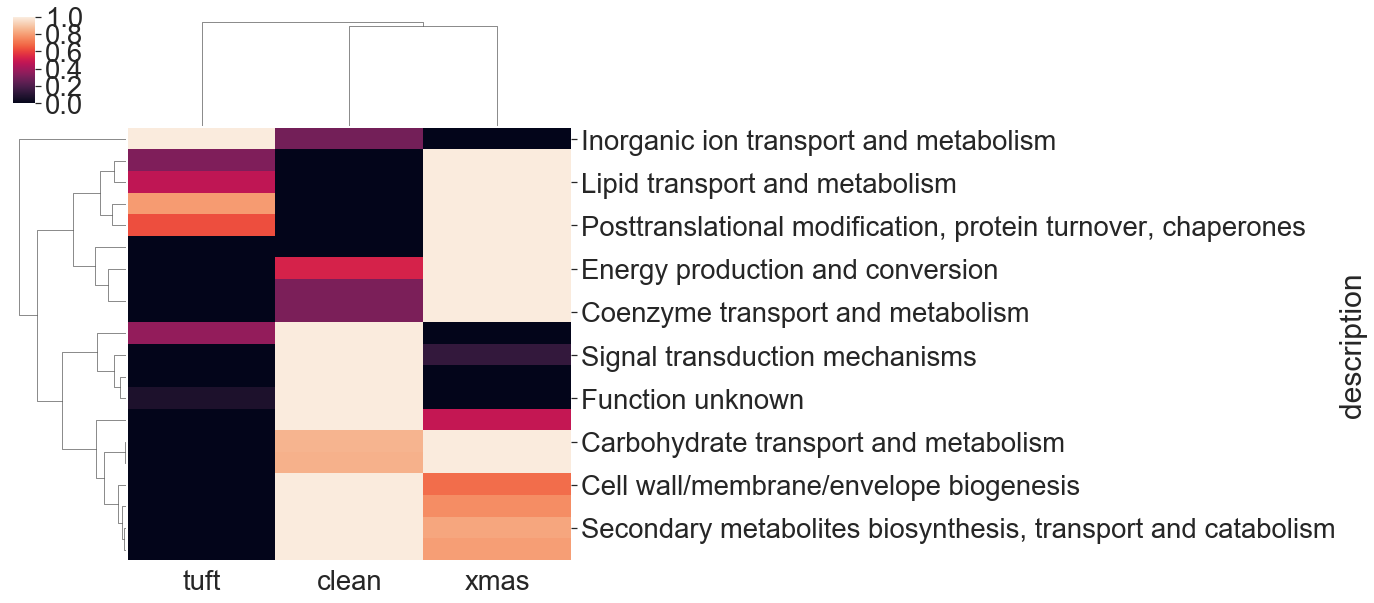

In [70]:
# need to map COGs to cog functions
cogdb = pd.read_csv("/Users/noelle/Documents/science_projects/180912_singlecolonies/august2019/eric_research/cognames2003-2014.csv", encoding='cp1252')
cogdb.drop('name', inplace=True, axis=1)
alldataCOG = alldata.merge(cogdb, left_on='COG_accession', right_on='COG', how='left')

COGmap = pd.read_csv("/Users/noelle/Documents/science_projects/180912_singlecolonies/august2019/eric_research/COGMap.csv", encoding='cp1252', header=None)
COGmap.columns = ['COG' ,'description']
COGmap.set_index("COG")
COGmap['description'] = COGmap['description'].str.split("Ê").apply(lambda x: x[-1])
COGdict = COGmap.to_dict()

# grab Tricho proteins only
alldataCOGTricho = alldataCOG[alldataCOG['taxonomy'] != 'Trichodesmium']
trichogrouped = alldataCOGTricho.groupby('func').sum().iloc[:,1:-6].transpose()
trichogrouped['type'] = trichogrouped.index.str[:-2]
trichogrouped = trichogrouped.groupby('type').mean()
trichogrouped.drop('cored', inplace=True)
trichogrouped = trichogrouped.transpose()

# if in multiple COGs double count to those COGs
letterDict = {}    
for letter in COGmap['COG'].values:
    filtered_df = trichogrouped.filter(regex=r'{}'.format(letter), axis=0)
    filtsum = filtered_df.sum()
    letterDict[letter] = filtsum
toplot = pd.DataFrame.from_dict(letterDict)


toplot = toplot.transpose().drop(['A','B','Z','Y', 'W']).reset_index()
toplot2 = toplot.merge(COGmap, right_on='COG', left_on='index')
toplot2.set_index('description', inplace=True)
toplot2.drop(['COG', 'index'], axis=1, inplace=True)
#toplot.rename(index=COGdict, inplace=True)
sns.clustermap(toplot2, standard_scale=0)
